In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from more_itertools import windowed, flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



tqdm.pandas()

In [2]:
corpus = pd.read_csv("../data/rom_real_dataset_final.csv")
corpus = corpus[["author", "title", "epoch", "text", "pub_year_estim"]]

### Sequence Shuffling

In [3]:
test_dataset_sf = pd.read_csv("../data/testdataset_longformer_sf.csv")
test_dataset_sf = test_dataset_sf.drop(columns=["input_ids", "attention_mask"])
test_dataset_sf.shape

(1214, 9)

In [4]:
test_dataset_sf

,part_index,author,title,epoch,pub_year_estim,text,labels,pred,match
0,0,"Alexis,-Willibald",Die Hosen des Herrn von Bredow,realismus,1846.0,1. Kapitel. Die Herbstwäsche\n \n \n \n \n \n ...,0,0,1
1,0,"Alexis,-Willibald",Die Hosen des Herrn von Bredow,realismus,1846.0,1. Kapitel. Die Herbstwäsche\n \n \n \n \n \n ...,1,1,1
2,1,"Alexis,-Willibald",Die Hosen des Herrn von Bredow,realismus,1846.0,"Nun ja, lieber Gott, wir haben kein Schloß Fri...",0,0,1
3,1,"Alexis,-Willibald",Die Hosen des Herrn von Bredow,realismus,1846.0,"Nun ja, lieber Gott, wir haben kein Schloß Fri...",1,1,1
4,2,"Alexis,-Willibald",Die Hosen des Herrn von Bredow,realismus,1846.0,Vor Schrecken war der Anne Susanne der Silberr...,0,0,1
...,...,...,...,...,...,...,...,...,...
1209,5,"Waiblinger,-Wilhelm",Die Briten in Rom,romantik,1828.0,"Es stiegen wohl zuweilen Zweifel in ihm auf, w...",1,1,1
1210,0,"Waiblinger,-Wilhelm",Das Märchen von der blauen Grotte,romantik,1828.0,"Zuerst will ich Euch den Titel sagen, den mein...",0,0,1
1211,0,"Waiblinger,-Wilhelm",Das Märchen von der blauen Grotte,romantik,1828.0,"Zuerst will ich Euch den Titel sagen, den mein...",1,1,1
1212,1,"Waiblinger,-Wilhelm",Das Märchen von der blauen Grotte,romantik,1828.0,Da öffnete sich die Felswand über der Jungfrau...,0,0,1


In [5]:
test_dataset_sf.groupby("epoch").part_index.count()

epoch
realismus    600
romantik     614
Name: part_index, dtype: int64

In [6]:
print(classification_report(test_dataset_sf["labels"], test_dataset_sf["pred"]))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       607
           1       0.91      0.79      0.84       607

    accuracy                           0.85      1214
   macro avg       0.86      0.85      0.85      1214
weighted avg       0.86      0.85      0.85      1214



In [7]:
print(classification_report(test_dataset_sf.query("epoch == 'romantik'")["labels"], test_dataset_sf.query("epoch == 'romantik'")["pred"]))

              precision    recall  f1-score   support

           0       0.72      0.93      0.81       307
           1       0.89      0.63      0.74       307

    accuracy                           0.78       614
   macro avg       0.80      0.78      0.77       614
weighted avg       0.80      0.78      0.77       614



In [8]:
print(classification_report(test_dataset_sf.query("epoch == 'realismus'")["labels"], test_dataset_sf.query("epoch == 'realismus'")["pred"]))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       300
           1       0.92      0.94      0.93       300

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



In [9]:
g_df_sf = (test_dataset_sf.groupby(["epoch", "title", "author"]).match.sum() / test_dataset_sf.groupby(["epoch", "title"]).match.count()).to_frame().reset_index().rename({"match": "Accuracy"}, axis=1)
g_df_sf["pub_year_estim"] = [corpus.query("title == @title").iloc[0]["pub_year_estim"] for title in g_df_sf.title]

In [10]:
from sklearn.metrics import recall_score, precision_score, f1_score

for index, row in g_df_sf.iterrows():
    title = row["title"]
    title_df = test_dataset_sf.query("title == @title")
    true, pred = title_df["labels"], title_df["pred"]
    g_df_sf.loc[index, "Precision"] = precision_score(true, pred)
    g_df_sf.loc[index, "Recall"] = recall_score(true, pred)
    g_df_sf.loc[index, "F1-Score"] = f1_score(true, pred)

/home/keller/.conda/envs/stilometry/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
g_df_sf.sort_values("Accuracy", ascending=False).head(10)

,epoch,title,author,Accuracy,pub_year_estim,Precision,Recall,F1-Score
31,romantik,Das Märchen von der blauen Grotte,"Waiblinger,-Wilhelm",1.0,1828.0,1.0,1.0,1.0
18,realismus,Im alten Eisen,"Raabe,-Wilhelm",1.0,1887.0,1.0,1.0,1.0
39,romantik,Die drei liebreichen Schwestern und der glückl...,"Arnim,-Ludwig-Achim-von",1.0,1806.0,1.0,1.0,1.0
19,realismus,Immensee,"Storm,-Theodor",1.0,1852.0,1.0,1.0,1.0
21,realismus,Kleider machen Leute,"Keller,-Gottfried",1.0,1854.0,1.0,1.0,1.0
1,realismus,Barthli der Korber,"Gotthelf,-Jeremias",1.0,1825.0,1.0,1.0,1.0
12,realismus,Die einsamen Kinder,"Hebbel,-Friedrich",1.0,1838.0,1.0,1.0,1.0
11,realismus,Die Söhne des Senators,"Storm,-Theodor",1.0,1852.0,1.0,1.0,1.0
35,romantik,Die Glücksritter,"Eichendorff,-Joseph-von",1.0,1822.0,1.0,1.0,1.0
9,realismus,Die Judenbuche,"Droste-Huelshoff,-Annette-von",1.0,1839.0,1.0,1.0,1.0


In [12]:
g_df_sf.sort_values("Accuracy", ascending=False).tail(10)

,epoch,title,author,Accuracy,pub_year_estim,Precision,Recall,F1-Score
49,romantik,Lucinde,"Schlegel,-Friedrich",0.750000,1799.0,1.000000,0.500000,0.666667
30,romantik,Das Marmorbild,"Eichendorff,-Joseph-von",0.750000,1816.0,0.666667,1.000000,0.800000
45,romantik,Goethes Briefwechsel mit einem Kinde,"Arnim,-Bettina-von",0.689655,1835.0,1.000000,0.379310,0.550000
36,romantik,Die Günderode,"Arnim,-Bettina-von",0.687500,1840.0,0.909091,0.416667,0.571429
37,romantik,Die Nachtwachen des Bonaventura,"Klingemann,-August",0.666667,1804.0,0.600000,1.000000,0.750000
42,romantik,Geschichte des Herrn William Lovell,"Tieck,-Ludwig",0.574074,1795.0,1.000000,0.148148,0.258065
38,romantik,Die Teutschen Volksbücher,"Goerres,-Joseph",0.550000,1812.0,1.000000,0.100000,0.181818
28,romantik,Clemens Brentanos Frühlingskranz,"Arnim,-Bettina-von",0.533333,1844.0,1.000000,0.066667,0.125000
46,romantik,Heinrich von Ofterdingen,Novalis,0.500000,1802.0,0.000000,0.000000,0.000000
43,romantik,Geschichte vom braven Kasperl und dem schönen ...,"Brentano,-Clemens",0.500000,1810.0,0.500000,1.000000,0.666667


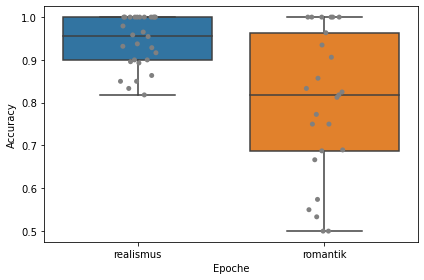

In [13]:
fig, ax = plt.subplots()
sns.boxplot(x="Epoche", y="Accuracy", ax=ax, data=g_df_sf.rename({"epoch": "Epoche"}, axis=1))
sns.stripplot(x="Epoche", y="Accuracy", color="gray", ax=ax, data=g_df_sf.rename({"epoch": "Epoche"}, axis=1))
fig.tight_layout()
fig.savefig("../plots/sf_acc_box.png", dpi=200)

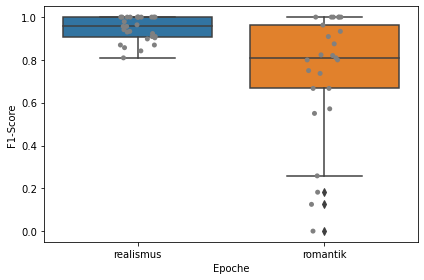

In [14]:
fig, ax = plt.subplots()
sns.boxplot(x="Epoche", y="F1-Score", ax=ax, data=g_df_sf.rename({"epoch": "Epoche"}, axis=1))
sns.stripplot(x="Epoche", y="F1-Score", color="gray", ax=ax, data=g_df_sf.rename({"epoch": "Epoche"}, axis=1))
fig.tight_layout()
fig.savefig("../plots/sf_f1_box.png", dpi=200)

<AxesSubplot:xlabel='Epoche', ylabel='Score'>

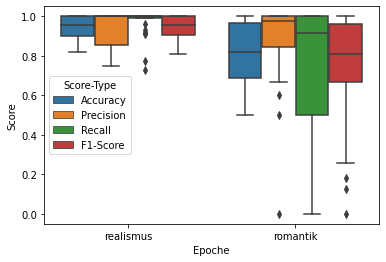

In [15]:
sns.boxplot(x="Epoche", y="Score", hue="Score-Type", data=g_df_sf.melt(id_vars=["title", "epoch", "author", "pub_year_estim"], var_name="Score-Type", value_name="Score").rename({"epoch": "Epoche"}, axis=1))

In [16]:
g_df_sf = g_df_sf.merge(test_dataset_sf.groupby(["title"]).describe().reset_index()[[("title", ''), ('part_index', 'count')]], left_on="title", right_on="title").rename({("part_index", "count"): "Anzahl Teiltexte"}, axis=1)

/home/keller/.conda/envs/stilometry/lib/python3.9/site-packages/pandas/core/frame.py:9190: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(
/home/keller/.conda/envs/stilometry/lib/python3.9/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


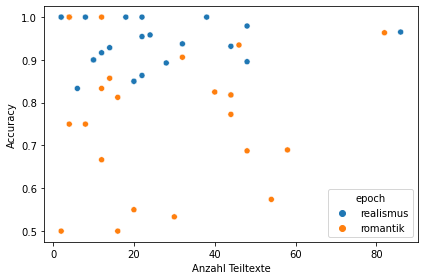

In [17]:
fig, ax = plt.subplots()
sns.scatterplot(x="Anzahl Teiltexte", y="Accuracy", hue="epoch", ax=ax, data=g_df_sf)
fig.tight_layout()
fig.savefig("../plots/sf-scatter-nparts-acc.png", dpi=200)

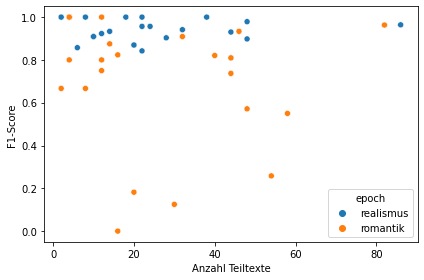

In [18]:
fig, ax = plt.subplots()
sns.scatterplot(x="Anzahl Teiltexte", y="F1-Score", hue="epoch", ax=ax, data=g_df_sf)
fig.tight_layout()
fig.savefig("../plots/sf-scatter-nparts-f1.png", dpi=200)

### NSP

In [19]:
test_dataset_nsp = pd.read_csv("../data/testdataset_bert.csv")
test_dataset_nsp.shape

(349100, 11)

In [20]:
print(classification_report(test_dataset_nsp["labels"], test_dataset_nsp["pred"]))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78    174550
           1       0.80      0.72      0.76    174550

    accuracy                           0.77    349100
   macro avg       0.77      0.77      0.77    349100
weighted avg       0.77      0.77      0.77    349100



In [21]:
print(classification_report(test_dataset_nsp.query("epoch == 'romantik'")["labels"], test_dataset_nsp.query("epoch == 'romantik'")["pred"]))

              precision    recall  f1-score   support

           0       0.74      0.84      0.79     77563
           1       0.81      0.70      0.75     77563

    accuracy                           0.77    155126
   macro avg       0.78      0.77      0.77    155126
weighted avg       0.78      0.77      0.77    155126



In [22]:
print(classification_report(test_dataset_nsp.query("epoch == 'realismus'")["labels"], test_dataset_nsp.query("epoch == 'realismus'")["pred"]))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78     96987
           1       0.80      0.73      0.76     96987

    accuracy                           0.77    193974
   macro avg       0.77      0.77      0.77    193974
weighted avg       0.77      0.77      0.77    193974



In [23]:
g_df_nsp = (test_dataset_nsp.groupby(["epoch", "title", "author"]).match.sum() / test_dataset_nsp.groupby(["epoch", "title"]).match.count()).to_frame().reset_index().rename({"match": "Accuracy"}, axis=1)
g_df_nsp["n_sents"] = [len(test_dataset_nsp.query("title == @title").drop_duplicates("sent1_idx")) for title in g_df_nsp.title]
g_df_nsp["pub_year_estim"] = [corpus.query("title == @title").iloc[0]["pub_year_estim"] for title in g_df_nsp.title]

In [24]:
from sklearn.metrics import recall_score, precision_score, f1_score

for index, row in g_df_nsp.iterrows():
    title = row["title"]
    title_df = test_dataset_nsp.query("title == @title")
    true, pred = title_df["labels"], title_df["pred"]
    g_df_nsp.loc[index, "Precision"] = precision_score(true, pred)
    g_df_nsp.loc[index, "Recall"] = recall_score(true, pred)
    g_df_nsp.loc[index, "F1-Score"] = f1_score(true, pred)

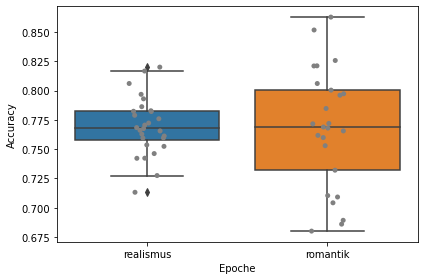

In [25]:
fig, ax = plt.subplots()
sns.boxplot(x="Epoche", y="Accuracy", ax=ax, data=g_df_nsp.rename({"epoch": "Epoche"}, axis=1))
sns.stripplot(x="Epoche", y="Accuracy", color="gray", ax=ax, data=g_df_nsp.rename({"epoch": "Epoche"}, axis=1))
fig.tight_layout()
fig.savefig("../plots/nsp_acc_box.png", dpi=200)

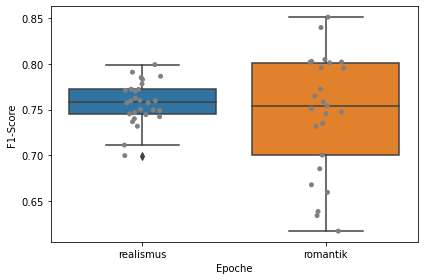

In [26]:
fig, ax = plt.subplots()
sns.boxplot(x="Epoche", y="F1-Score", ax=ax, data=g_df_nsp.rename({"epoch": "Epoche"}, axis=1))
sns.stripplot(x="Epoche", y="F1-Score", color="gray", ax=ax, data=g_df_nsp.rename({"epoch": "Epoche"}, axis=1))
fig.tight_layout()
fig.savefig("../plots/nsp_f1_box.png", dpi=200)

<AxesSubplot:xlabel='Epoche', ylabel='Score'>

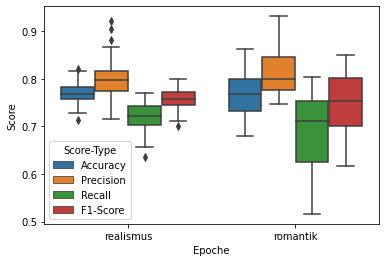

In [27]:
sns.boxplot(x="Epoche", y="Score", hue="Score-Type", data=g_df_nsp.melt(id_vars=["title", "epoch", "author", "n_sents", "pub_year_estim"], var_name="Score-Type", value_name="Score").rename({"epoch": "Epoche"}, axis=1))

<AxesSubplot:xlabel='pub_year_estim', ylabel='F1-Score'>

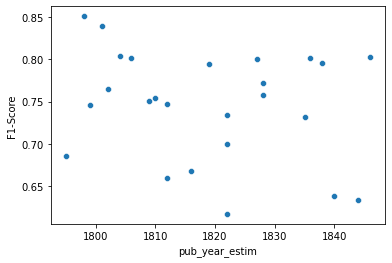

In [28]:
sns.scatterplot(x="pub_year_estim",y="F1-Score", data=g_df_nsp.query("epoch == 'romantik'"))

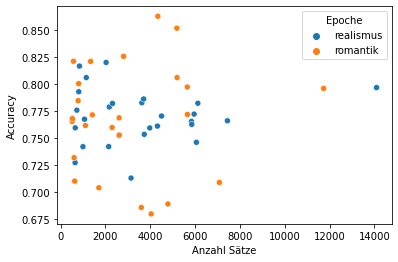

In [29]:
g = sns.scatterplot(x="Anzahl Sätze", y="Accuracy", hue="Epoche", data=g_df_nsp.rename({"epoch": "Epoche", "n_sents": "Anzahl Sätze"}, axis=1))
g.figure.savefig("../plots/nsp_n_sents_acc_scatter.png", dpi=200)

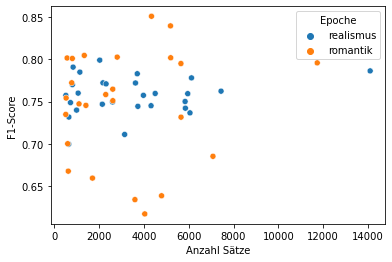

In [30]:
g = sns.scatterplot(x="Anzahl Sätze", y="F1-Score", hue="Epoche", data=g_df_nsp.rename({"epoch": "Epoche", "n_sents": "Anzahl Sätze"}, axis=1))
g.figure.savefig("../plots/nsp_n_sents_f1_scatter.png", dpi=200)

In [31]:
g_df_nsp.query("epoch == 'romantik'").sort_values("Accuracy", ascending=False).head(10)

,epoch,title,author,Accuracy,n_sents,pub_year_estim,Precision,Recall,F1-Score
40,romantik,Franz Sternbalds Wanderungen,"Tieck,-Ludwig",0.862693,4337,1798.0,0.931195,0.783260,0.850845
44,romantik,Godwi oder Das steinerne Bild der Mutter,"Brentano,-Clemens",0.851688,5185,1801.0,0.914903,0.775506,0.839457
29,romantik,Das Leben der Hochgräfin Gritta von Rattenzuha...,"Arnim,-Bettina-von",0.825677,2808,1846.0,0.925151,0.708689,0.802581
39,romantik,Die drei liebreichen Schwestern und der glückl...,"Arnim,-Ludwig-Achim-von",0.821117,573,1806.0,0.900000,0.722513,0.801549
37,romantik,Die Nachtwachen des Bonaventura,"Klingemann,-August",0.821001,1338,1804.0,0.885894,0.736921,0.804570
33,romantik,Der junge Tischlermeister,"Tieck,-Ludwig",0.806026,5194,1836.0,0.819626,0.784752,0.801810
51,romantik,Phantasien im Bremer Ratskeller,"Hauff,-Wilhelm",0.800373,804,1827.0,0.798517,0.803483,0.800992
48,romantik,Lebensansichten des Katers Murr,"Hoffmann,-E.-T.-A.",0.797293,5651,1819.0,0.804127,0.786056,0.794989
50,romantik,Münchhausen,"Immermann,-Karl",0.796045,11733,1838.0,0.796804,0.794767,0.795784
31,romantik,Das Märchen von der blauen Grotte,"Waiblinger,-Wilhelm",0.784704,778,1828.0,0.819625,0.730077,0.772264


In [32]:
g_df_nsp.query("epoch == 'romantik'").sort_values("Accuracy", ascending=False).tail(10)

,epoch,title,author,Accuracy,n_sents,pub_year_estim,Precision,Recall,F1-Score
47,romantik,Isabella von Ägypten,"Arnim,-Ludwig-Achim-von",0.761775,1104,1812.0,0.795501,0.704710,0.747358
34,romantik,Die Briten in Rom,"Waiblinger,-Wilhelm",0.759904,2297,1828.0,0.763228,0.753592,0.758379
52,romantik,Reiseschatten. Von dem Schattenspieler Luchs,"Kerner,-Justinus",0.752966,2613,1809.0,0.756799,0.745503,0.751109
32,romantik,Das Schloß Dürande,"Eichendorff,-Joseph-von",0.732053,599,1822.0,0.794492,0.626043,0.700280
30,romantik,Das Marmorbild,"Eichendorff,-Joseph-von",0.710400,625,1816.0,0.782796,0.582400,0.667890
42,romantik,Geschichte des Herrn William Lovell,"Tieck,-Ludwig",0.709181,7080,1795.0,0.746423,0.633616,0.685409
38,romantik,Die Teutschen Volksbücher,"Goerres,-Joseph",0.704225,1704,1812.0,0.776630,0.573357,0.659689
36,romantik,Die Günderode,"Arnim,-Bettina-von",0.689302,4786,1840.0,0.762761,0.549519,0.638815
28,romantik,Clemens Brentanos Frühlingskranz,"Arnim,-Bettina-von",0.686024,3599,1844.0,0.759396,0.544596,0.634304
41,romantik,Geschichte der poetischen Literatur Deutschlands,"Eichendorff,-Joseph-von",0.680084,4037,1822.0,0.767870,0.516225,0.617390


In [33]:
g_df_nsp.query("epoch == 'realismus'").sort_values("Accuracy", ascending=False).head(10)

,epoch,title,author,Accuracy,n_sents,pub_year_estim,Precision,Recall,F1-Score
10,realismus,Die Poggenpuhls,"Fontane,-Theodor",0.820020,2028,1895.0,0.904613,0.715483,0.799009
22,realismus,Ledwina,"Droste-Huelshoff,-Annette-von",0.816667,840,1822.0,0.920886,0.692857,0.790761
1,realismus,Barthli der Korber,"Gotthelf,-Jeremias",0.806042,1142,1825.0,0.881134,0.707531,0.784847
13,realismus,Die verlorene Handschrift,"Freytag,-Gustav",0.796793,14094,1864.0,0.829111,0.747694,0.786301
17,realismus,Gustav Adolfs Page,"Meyer,-Conrad-Ferdinand",0.792954,809,1861.0,0.865741,0.693449,0.770075
20,realismus,Jürg Jenatsch,"Meyer,-Conrad-Ferdinand",0.786254,3703,1876.0,0.795265,0.770996,0.782943
16,realismus,Graf Petöfy,"Fontane,-Theodor",0.782777,3623,1884.0,0.812252,0.735578,0.772016
5,realismus,Der Hungerpastor,"Raabe,-Wilhelm",0.782342,6122,1863.0,0.793713,0.762986,0.778046
25,realismus,Unterm Birnbaum,"Fontane,-Theodor",0.782129,2311,1885.0,0.812560,0.733449,0.770980
0,realismus,Angela Borgia,"Meyer,-Conrad-Ferdinand",0.778904,2171,1891.0,0.796378,0.749424,0.772188


In [34]:
g_df_nsp.query("epoch == 'realismus'").sort_values("Accuracy", ascending=False).tail(10)

,epoch,title,author,Accuracy,n_sents,pub_year_estim,Precision,Recall,F1-Score
27,realismus,Zwischen Himmel und Erde,"Ludwig,-Otto",0.761232,4318,1856.0,0.798887,0.698240,0.745180
19,realismus,Immensee,"Storm,-Theodor",0.759601,651,1852.0,0.827519,0.655914,0.731791
2,realismus,Bozena,"Ebner-Eschenbach,-Marie-von",0.759492,3977,1876.0,0.763939,0.751069,0.757449
3,realismus,Das Gemeindekind,"Ebner-Eschenbach,-Marie-von",0.753619,3730,1887.0,0.773252,0.717694,0.744438
18,realismus,Im alten Eisen,"Raabe,-Wilhelm",0.752403,2601,1887.0,0.758160,0.741253,0.749611
24,realismus,Uli der Pächter,"Gotthelf,-Jeremias",0.746243,6055,1849.0,0.765397,0.710157,0.736743
4,realismus,Der Heilige,"Meyer,-Conrad-Ferdinand",0.742304,2144,1880.0,0.733693,0.760728,0.746966
6,realismus,Der Schuß von der Kanzel,"Meyer,-Conrad-Ferdinand",0.742211,995,1861.0,0.746421,0.733668,0.739990
11,realismus,Die Söhne des Senators,"Storm,-Theodor",0.727484,644,1852.0,0.779048,0.635093,0.699743
23,realismus,Stopfkuchen. Eine See- und Mordgeschichte,"Raabe,-Wilhelm",0.713217,3140,1891.0,0.716177,0.706369,0.711239


In [35]:
matches = []
for title in test_dataset_nsp.title.unique():
    title_df = test_dataset_nsp.query("title == @title and labels == 0")
    title_df = title_df.sort_values(by="sent1_idx")
    match = title_df["match"].to_list()
    matches.append(match)

matches = np.array([
    entry + [-1] * (max([len(i) for i in matches]) - len(entry))
    for entry in matches
])
matches = pd.DataFrame(matches, index=test_dataset_nsp.title.unique())
matches.head(3)

,0,1,2,3,4,5,6,7,8,9,...,14084,14085,14086,14087,14088,14089,14090,14091,14092,14093
Die Hosen des Herrn von Bredow,1,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Das Leben der Hochgräfin Gritta von Rattenzuhausbeiuns,1,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
Clemens Brentanos Frühlingskranz,1,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [36]:
titles_rom = test_dataset_nsp.query("epoch == 'romantik'").title.unique().tolist()
titles_rea = test_dataset_nsp.query("epoch == 'realismus'").title.unique().tolist()

<AxesSubplot:>

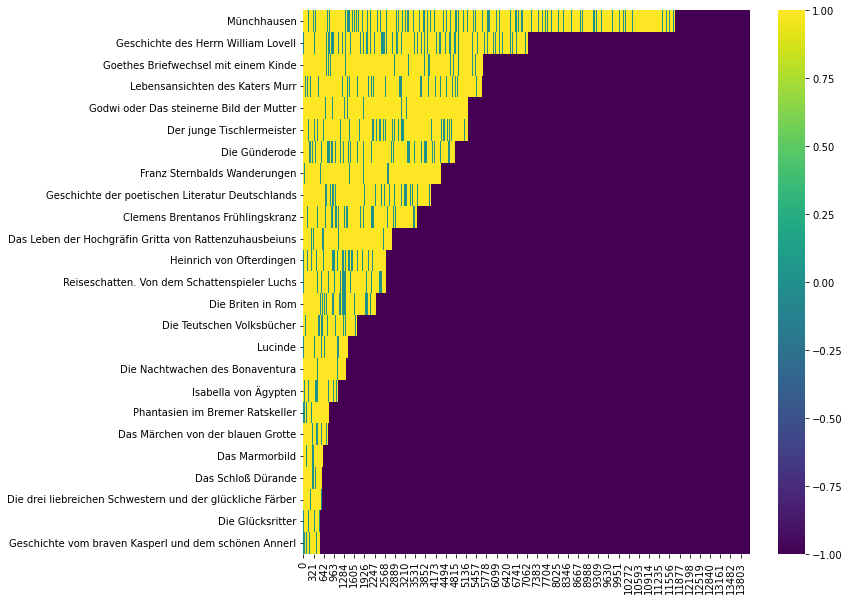

In [37]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(matches.query("index in @titles_rom").iloc[matches.query("index in @titles_rom").sum(axis=1).argsort()[::-1]], ax=ax, cmap="viridis")

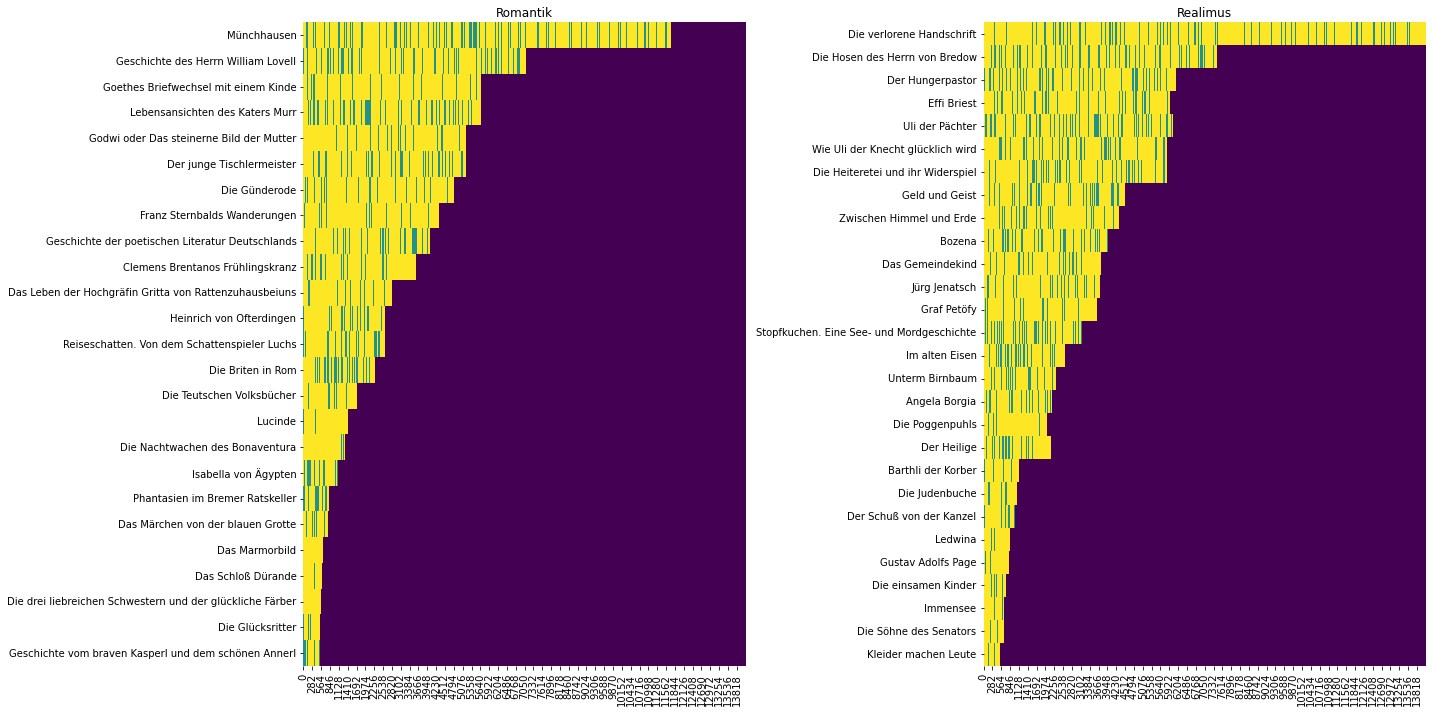

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].set_title("Romantik")
sns.heatmap(matches.query("index in @titles_rom").iloc[matches.query("index in @titles_rom").sum(axis=1).argsort()[::-1]], cbar=False, ax=axs[0], cmap="viridis")
axs[1].set_title("Realimus")
sns.heatmap(matches.query("index in @titles_rea").iloc[matches.query("index in @titles_rea").sum(axis=1).argsort()[::-1]], cbar=False, ax=axs[1], cmap="viridis")
fig.tight_layout()
fig.savefig("../plots/nsp_heat_fingerprint.png", dpi=200)
plt.show()

In [39]:
from more_itertools import divide
def fixed_window_mean(mat, window_size=100, padding_value=-1):
    means = []
    for x in mat:
        x = x[x != padding_value]
        x = list(x)
        means.append([np.mean(list(w)) for w in divide(window_size, x)])
    means = np.array(means)
    return means

#def fixed_window_mean(mat, window_size=100, padding_value=-1):
#    means = []
#    for x in mat:
#        x = x[x != padding_value]
#        idc = np.arange(len(x))
#        begin_idc = idc[:round(len(idc)*0.1)]
#        end_idc = idc[-round(len(idc)*0.1):]
#        middle_idc = idc[len(begin_idc):-len(end_idc)]
#        
#        begin = x[begin_idc]
#        middle = x[middle_idc]
#        end = x[end_idc]
#        means.append([begin.mean(), middle.mean(), end.mean()])
#    means = np.array(means)
#    return means

In [40]:
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from tslearn.svm import TimeSeriesSVC
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")

epochs = [test_dataset_nsp.query("title == @title").iloc[0].epoch for title in test_dataset_nsp.title.unique()]
le = LabelEncoder()
y = le.fit_transform(epochs)
window_size_calibration_score_dfs = []
for ws in tqdm(list(range(5, 100, 5))):
    
    fixed_window_means = fixed_window_mean(matches.to_numpy(), window_size=ws)
    epochs = [test_dataset_nsp.query("title == @title").iloc[0].epoch for title in test_dataset_nsp.title.unique()]
    fixed_window_means = pd.DataFrame(fixed_window_means, index=epochs)
    #fixed_window_means = pd.DataFrame(data=zscore(fixed_window_means, axis=0), index=fixed_window_means.index)
    
    cv_scores = pd.DataFrame(cross_validate(
        estimator=KNeighborsTimeSeriesClassifier(n_neighbors=7),
        X=fixed_window_means,
        y=y,
        scoring=["f1", "f1_macro", "f1_micro", "accuracy"],
        cv=RepeatedStratifiedKFold(n_repeats=100, n_splits=3, random_state=42),
        n_jobs=12
    ))
    cv_scores["ws"] = ws
    window_size_calibration_score_dfs.append(cv_scores)
window_size_calibration_score_df = pd.concat(window_size_calibration_score_dfs)

  0%|          | 0/19 [00:00<?, ?it/s]

<AxesSubplot:xlabel='ws', ylabel='test_f1'>

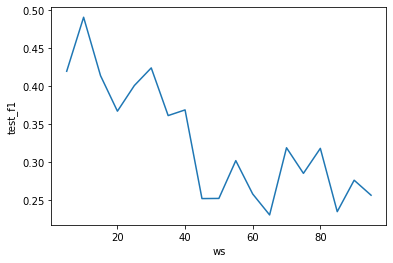

In [41]:
sns.lineplot(x="ws", y="test_f1", data=window_size_calibration_score_df.groupby("ws").mean())

In [42]:
fixed_window_means = fixed_window_mean(matches.to_numpy(), window_size=10)
epochs = [test_dataset_nsp.query("title == @title").iloc[0].epoch for title in test_dataset_nsp.title.unique()]
fixed_window_means = pd.DataFrame(fixed_window_means, index=epochs)

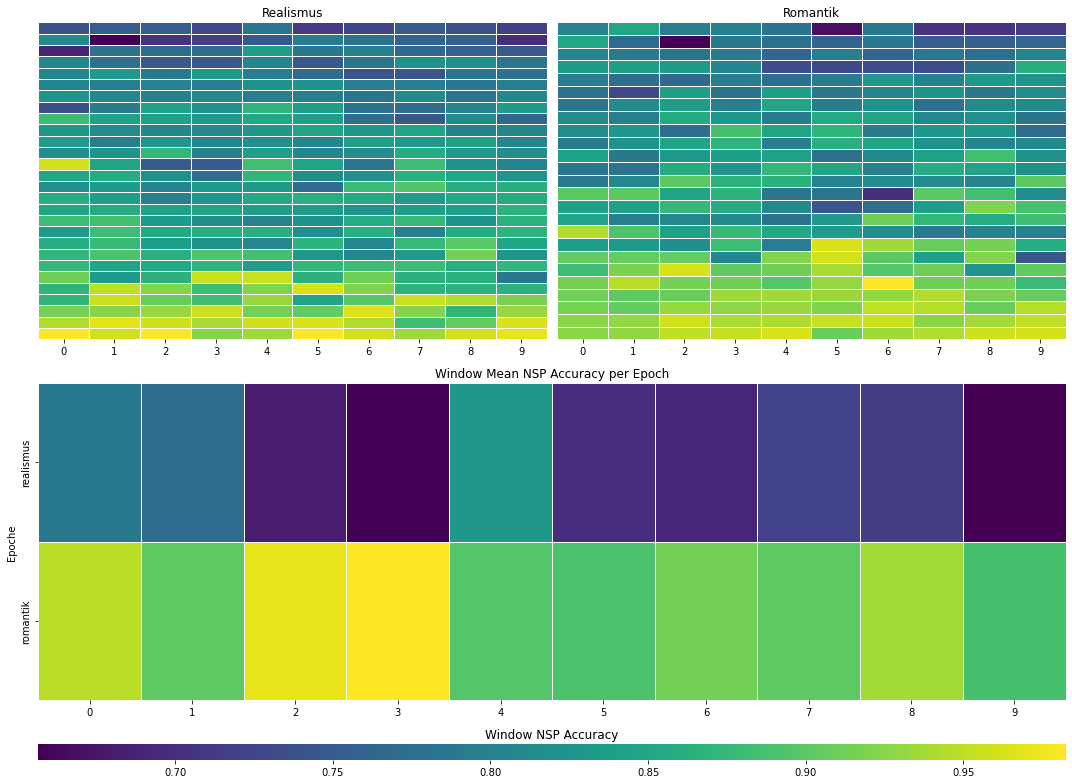

In [43]:
fig = plt.figure(figsize=(15, 11))
#gs = fig.add_gridspec(5,2, height_ratios=[2, 2, 0.1, 2, 0.1])
gs = fig.add_gridspec(3,2, height_ratios=[2, 2, 0.1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
ax4 = fig.add_subplot(gs[2, :])
#ax5 = fig.add_subplot(gs[3, :])
#ax6 = fig.add_subplot(gs[4, :])

fixed_window_means_rea = fixed_window_means.iloc[fixed_window_means.index == "realismus"]
fixed_window_means_rea = fixed_window_means_rea.iloc[fixed_window_means_rea.mean(axis=1).argsort()]
ax1.set_title("Realismus")
sns.heatmap(fixed_window_means_rea, cmap="viridis", ax=ax1, cbar=False, yticklabels=False, linewidths=.5)

fixed_window_means_rom = fixed_window_means.iloc[fixed_window_means.index == "romantik"]
fixed_window_means_rom = fixed_window_means_rom.iloc[fixed_window_means_rom.mean(axis=1).argsort()]

ax2.set_title("Romantik")
ax4.set_title("Window NSP Accuracy")
sns.heatmap(fixed_window_means_rom, cmap="viridis", ax=ax2, cbar=True, yticklabels=False, cbar_ax=ax4, cbar_kws={"orientation": "horizontal"}, linewidths=.5)

ax3.set_title("Window Mean NSP Accuracy per Epoch")
fixed_window_means_epoch = fixed_window_means.reset_index().rename({"index": "Epoche"}, axis=1).groupby("Epoche").mean()
sns.heatmap(fixed_window_means_epoch, ax=ax3, cmap="viridis", cbar=False, linewidths=.5)

#ax5.set_title("Window STD per Epoch")
#fixed_window_std_epoch = fixed_window_means.reset_index().rename({"index": "Epoche"}, axis=1).groupby("Epoche").std()
#sns.heatmap(fixed_window_std_epoch, ax=ax5, cmap="magma", cbar=True, linewidths=.5, cbar_ax=ax6, cbar_kws={"orientation": "horizontal"})
fig.savefig("../plots/nsp_window_mean_heat_10.png", dpi=200)
fig.tight_layout()

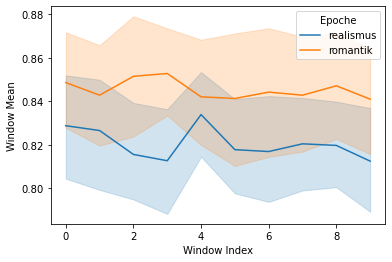

In [44]:
fig, ax = plt.subplots()
sns.lineplot(x="Window Index", y="Window Mean", hue="Epoche", data=fixed_window_means.reset_index().rename({"index": "Epoche"}, axis=1).melt(id_vars=["Epoche"], var_name="Window Index", value_name="Window Mean"), ax=ax)
fig.savefig("../plots/nsp_window_mean_line_10.png", dpi=200)

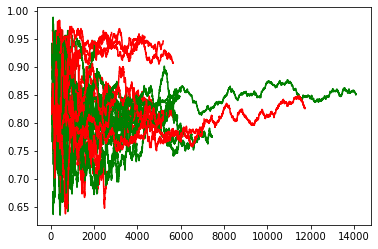

In [45]:
fig, ax = plt.subplots()
for title, row  in matches.iterrows():
    epoch = g_df_nsp.query("title == @title").epoch.iloc[0]
    s = row[row != -1]
    seq_len = len(s)
    rs = s.rolling(seq_len // 10).mean()
    ax.plot(rs, color="red" if epoch == "romantik" else "green")

In [46]:
def filter_singletons(matches: pd.DataFrame, window_size=2, window_sum=3, stride=None, padding_value=-1):
    if stride is None:
        stride = window_size
    # 1 = Correct, 0 = False
    data = matches.to_numpy().copy()
    filtered_data = []
    for entry in data:
        entry.copy()
        for idx in range(0, len(entry), stride):
            window_start = max(0, idx - window_size)
            window_end = min(idx + window_size, len(entry))
            window = entry[window_start:window_end]
            window = window[window != padding_value]
            if len(window) == 0:
                continue
            if window.sum() >= window_sum:
                entry[window_start:(window_end - len(window))] = 1

        filtered_data.append(entry)
    filtered_matches = pd.DataFrame(filtered_data, index=matches.index)
    return filtered_matches    

In [47]:
#matches_filtered = filter_singletons(matches, window_size=10, window_sum=19)
matches_filtered = matches

In [48]:
import matplotlib.pyplot as plt
plot_data_rom = []
plot_data_rea = []
for int_idx, (index, row) in enumerate(matches_filtered.iterrows()):
    title = matches_filtered.index[int_idx]
    epoch = test_dataset_nsp.query("title == @title").epoch.iloc[0]
    s = matches_filtered.loc[index].to_numpy()
    s = s[s != -1].reshape(1, -1)
    #s = pd.Series(s.ravel()).rolling(10).mean().dropna().to_numpy().reshape(1, -1)
    if epoch == "romantik":
        plot_data_rom.append({"title": title, "epoch": epoch, "s": s})
    else:
        plot_data_rea.append({"title": title, "epoch": epoch, "s": s})
plot_data_rom = list(sorted(plot_data_rom, key=lambda entry: entry["s"].ravel().shape[0]))
plot_data_rea = list(sorted(plot_data_rea, key=lambda entry: entry["s"].ravel().shape[0]))

plot_data = plot_data_rom + plot_data_rea
np.mean([entry["s"].mean() for entry in plot_data])

0.8323217209768544

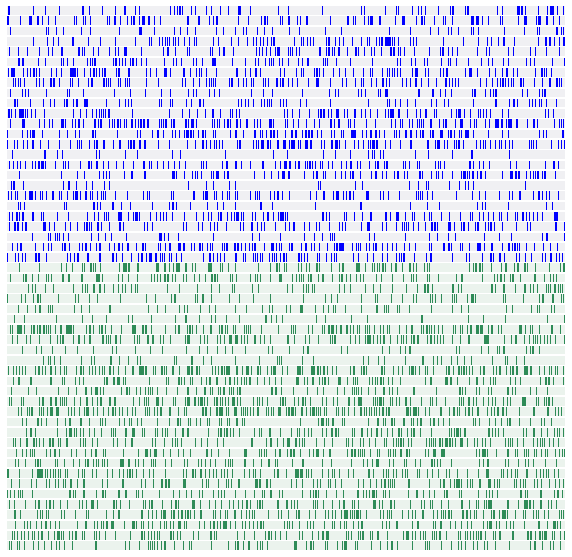

In [49]:
fig, axs = plt.subplots(len(plot_data), 1, figsize=(10,10))
for int_idx, entry in enumerate(plot_data):
    ax = axs[int_idx]
    epoch = entry["epoch"]
    title = entry["title"]
    s = entry["s"]
    sns.heatmap(
        s,
        ax=ax,
        cmap=sns.color_palette("light:b_r", as_cmap=True) if epoch == "romantik" else sns.light_palette("seagreen", reverse=True, as_cmap=True),
        cbar=False, yticklabels=False,
        xticklabels=False)
    #ax.set_title(title + " | " + epoch)
plt.show()

In [50]:
def compress_seq(seq):
    compressed = []
    index = 0
    while index < len(seq):
        curr = seq[index]
        start_index = index
        end_index = index + 1
        while end_index < len(seq):
            if seq[end_index] == curr:
                end_index += 1
            else:
                break
        compressed.append((curr, (start_index, end_index)))
        index = end_index
    return compressed

In [51]:
compression_ratios = {}
for index, row in matches.iterrows():
    s = "".join(map(str, row[row != -1].tolist()))
    compressed = compress_seq(s)
    compression_ratios[index] = len(s) / len(compressed)

In [52]:
s, len(s), compressed[1], compressed[-1]

('1111111111111110001110001111111111011011111011111111101111111101111111111110110111110111111101111011111111110110011001011010111111111111111111111111010001110101011100111110110001110101111011111101111111111111111111111110111111111110111101111110111111111111111011100110111101111111101110000001011111111111111111111101111111110110111101011101111111011101011111100111101101101111101011101111111101111111110111011110011101010111111111111111111110101101111111111100111111111111111111011110111111111111101111111111101111111111111111111111011101111111011101111111111111101111101111111111101111011011111111110111101111111110110111110101111011111111111011111111111111111011111111101111001111111111111001111101110111111111111111110111011010111110111111111111111111111111011111111111111100',
 778,
 ('0', (15, 18)),
 ('0', (776, 778)))

In [53]:
g_df_nsp = g_df_nsp.merge(pd.Series(compression_ratios, name="Kompressionsrate"), left_on="title", right_index=True)

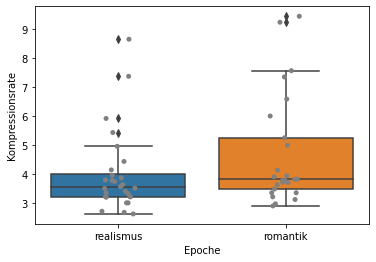

In [54]:
fig, ax = plt.subplots()
sns.boxplot(x="Epoche", y="Kompressionsrate", ax=ax, data=g_df_nsp.rename({"epoch": "Epoche"}, axis=1))
sns.stripplot(x="Epoche", y="Kompressionsrate", color="gray", ax=ax, data=g_df_nsp.rename({"epoch": "Epoche"}, axis=1))
fig.savefig("../plots/nsp_comp_rat.png", dpi=200)

In [55]:
g_df_nsp.sort_values(by="Kompressionsrate", ascending=False)

,epoch,title,author,Accuracy,n_sents,pub_year_estim,Precision,Recall,F1-Score,Kompressionsrate
29,romantik,Das Leben der Hochgräfin Gritta von Rattenzuha...,"Arnim,-Bettina-von",0.825677,2808,1846.0,0.925151,0.708689,0.802581,9.454545
40,romantik,Franz Sternbalds Wanderungen,"Tieck,-Ludwig",0.862693,4337,1798.0,0.931195,0.783260,0.850845,9.247335
22,realismus,Ledwina,"Droste-Huelshoff,-Annette-von",0.816667,840,1822.0,0.920886,0.692857,0.790761,8.659794
44,romantik,Godwi oder Das steinerne Bild der Mutter,"Brentano,-Clemens",0.851688,5185,1801.0,0.914903,0.775506,0.839457,7.569343
10,realismus,Die Poggenpuhls,"Fontane,-Theodor",0.820020,2028,1895.0,0.904613,0.715483,0.799009,7.374545
45,romantik,Goethes Briefwechsel mit einem Kinde,"Arnim,-Bettina-von",0.771972,5655,1835.0,0.888777,0.621751,0.731662,7.353706
39,romantik,Die drei liebreichen Schwestern und der glückl...,"Arnim,-Ludwig-Achim-von",0.821117,573,1806.0,0.900000,0.722513,0.801549,6.586207
37,romantik,Die Nachtwachen des Bonaventura,"Klingemann,-August",0.821001,1338,1804.0,0.885894,0.736921,0.804570,6.000000
1,realismus,Barthli der Korber,"Gotthelf,-Jeremias",0.806042,1142,1825.0,0.881134,0.707531,0.784847,5.917098
17,realismus,Gustav Adolfs Page,"Meyer,-Conrad-Ferdinand",0.792954,809,1861.0,0.865741,0.693449,0.770075,5.429530


In [56]:
def get_uncertainty_regions(title_df, threshold=5):
    title_df = title_df.iloc[::2]
    regions = []
    index = 0
    while index < len(title_df):
        if title_df.iloc[index]["match"] == 0:
            expand_window_start_index = index
            while index < len(title_df) and title_df.iloc[index]["match"] == 0:
                index += 1
            expand_window_end_index = index
            region_df = title_df.iloc[expand_window_start_index:expand_window_end_index]
            if len(region_df) >= max(threshold, 2):
                regions.append(region_df)
        else:
            index += 1
    return regions

In [57]:
title_dfs_nsp = {title: title_df.copy().reset_index(drop=True) for title, title_df in dict(tuple(test_dataset_nsp.groupby("title"))).items()}

In [58]:
uncertainty_regions = {}
for title, title_df in tqdm(title_dfs_nsp.items()):
    uncertainty_regions[title] = get_uncertainty_regions(title_df.copy(), threshold=3)

  0%|          | 0/53 [00:00<?, ?it/s]

In [59]:
def get_region_text(region_df, sep=" "):
    return sep.join(region_df["sent1"]) + sep + region_df["sent2"].iloc[-1]

In [60]:
get_region_text(uncertainty_regions["Die Günderode"][0])

'Karoline\n \n \n \n \n Wenn Du Muße findest, so schreib bald wieder. Beilage zum Brief der Günderode\n\n \n (Ein apokalyptisches Fragment)\n \n \n 1. Auf hohem Fels im Mittelmeer stand ich, vor mir der Ost, hinter mir der West, und der Wind ruhte auf der See. 2. Die Sonne sank, kaum war sie verhüllt im Niedergang, enthüllte im Aufgang sich das Morgenrot; Morgen, Mittag, Abend und Nacht jagten in schwindelnder Eile um des Himmels Bogen.'

In [61]:
unc_region_df = pd.concat(list(flatten([dfs for dfs in uncertainty_regions.values()])))
unc_region_df.shape

(4569, 11)

In [ ]:
sample_titles = g_df_nsp.query("epoch == 'romantik'").title.sample(2, random_state=42).tolist() + g_df_nsp.query("epoch == 'realismus'").title.sample(2, random_state=42).tolist()
sample_titles

['Die Günderode',
 'Godwi oder Das steinerne Bild der Mutter',
 'Die Judenbuche',
 'Unterm Birnbaum']

In [84]:
#for title in sample_titles:
#    regions = uncertainty_regions[title]
#    print(title)
#    for region in regions:
#        print(get_region_text(region))
#        print("_"*60)
#    print("#"*60)
#    print()

In [107]:
sample_regions = pd.Series(list(flatten([dfs for dfs in uncertainty_regions.values()]))).sample(2, random_state=346).tolist()
for region in sample_regions:
    title = region.iloc[0].title
    author = region.iloc[0].author
    epoch = region.iloc[0].epoch
    print(f"{author} | {title} ({epoch})")
    print(get_region_text(region))
    print()

Tieck,-Ludwig | Der junge Tischlermeister (romantik)
Leonhard blickte sinnend umher, und es schien ihm, als wenn das Eintreten in das kleine Haus, sowie die Entfernung der jungen Frau, etwas Abgeredetes sei, welches der Zufall nicht so herbeigeführt haben könne. Warum ihn dieser Argwohn, oder diese Entdeckung, statt ihn fröhlich zu machen, schwermütig stimme, begriff er selber nicht. Charlotte stand auf und sah aus dem Fenster; dann setzte sie sich wieder zu ihm und näher als zuvor, sah ihn mit ihrem süßen, verführerischen Lächeln an, und von den vollen roten Lippen sprang nur die einzige Silbe: "Nun?" "Wie glücklich bin ich", sagte er nach einer kleinen Pause "mich so an Ihrer Seite in dieser seligen Einsamkeit zu finden!"

Fontane,-Theodor | Graf Petöfy (realismus)
Etwas landeinwärts erhob sich Schloß Arpa steil und mächtig und überblickte den See. "Sieh", sagte der Graf und wies hinauf. Andras und Josephine blieben des Gepäckes halber zurück, und in einem leichten Korbwagen, dessen 

In [64]:
g_df_nsp = g_df_nsp.merge(pd.Series({title: len(regions) for title, regions in uncertainty_regions.items()}, name="N_Uncertainty_Regions"), left_on="title", right_index=True)
g_df_nsp = g_df_nsp.merge(pd.Series({title: np.mean([len(region) for region in regions]) for title, regions in uncertainty_regions.items()}, name="Uncertainty_Regions_Mean_Length"), left_on="title", right_index=True)
g_df_nsp = g_df_nsp.merge(pd.Series({title: np.sum([len(region) for region in regions]) for title, regions in uncertainty_regions.items()}, name="Uncertainty_Regions_Sum_Length"), left_on="title", right_index=True)


g_df_nsp["Rel_Uncertainty_Regions"] = g_df_nsp["Uncertainty_Regions_Sum_Length"] / g_df_nsp["n_sents"]

g_df_nsp.head(10)

,epoch,title,author,Accuracy,n_sents,pub_year_estim,Precision,Recall,F1-Score,Kompressionsrate,N_Uncertainty_Regions,Uncertainty_Regions_Mean_Length,Uncertainty_Regions_Sum_Length,Rel_Uncertainty_Regions
0,realismus,Angela Borgia,"Meyer,-Conrad-Ferdinand",0.778904,2171,1891.0,0.796378,0.749424,0.772188,3.507270,23,3.434783,79.0,0.036389
1,realismus,Barthli der Korber,"Gotthelf,-Jeremias",0.806042,1142,1825.0,0.881134,0.707531,0.784847,5.917098,1,3.000000,3.0,0.002627
2,realismus,Bozena,"Ebner-Eschenbach,-Marie-von",0.759492,3977,1876.0,0.763939,0.751069,0.757449,2.994729,47,3.425532,161.0,0.040483
3,realismus,Das Gemeindekind,"Ebner-Eschenbach,-Marie-von",0.753619,3730,1887.0,0.773252,0.717694,0.744438,3.207223,37,3.405405,126.0,0.033780
4,realismus,Der Heilige,"Meyer,-Conrad-Ferdinand",0.742304,2144,1880.0,0.733693,0.760728,0.746966,2.611449,44,3.477273,153.0,0.071362
5,realismus,Der Hungerpastor,"Raabe,-Wilhelm",0.782342,6122,1863.0,0.793713,0.762986,0.778046,3.318157,49,3.510204,172.0,0.028095
6,realismus,Der Schuß von der Kanzel,"Meyer,-Conrad-Ferdinand",0.742211,995,1861.0,0.746421,0.733668,0.739990,2.703804,9,3.333333,30.0,0.030151
7,realismus,Die Heiteretei und ihr Widerspiel,"Ludwig,-Otto",0.765547,5837,1857.0,0.802853,0.703958,0.750160,3.734485,44,3.159091,139.0,0.023814
8,realismus,Die Hosen des Herrn von Bredow,"Alexis,-Willibald",0.766093,7441,1846.0,0.774695,0.750437,0.762373,3.188089,86,3.418605,294.0,0.039511
9,realismus,Die Judenbuche,"Droste-Huelshoff,-Annette-von",0.767606,1065,1839.0,0.785571,0.736150,0.760058,3.338558,11,3.181818,35.0,0.032864


<AxesSubplot:xlabel='epoch', ylabel='Rel_Uncertainty_Regions'>

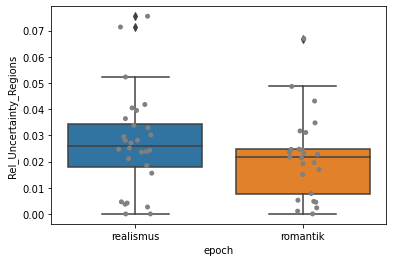

In [65]:
sns.boxplot(x="epoch", y="Rel_Uncertainty_Regions", data=g_df_nsp)
sns.stripplot(x="epoch", y="Rel_Uncertainty_Regions", color="gray", data=g_df_nsp)

<AxesSubplot:xlabel='epoch', ylabel='Uncertainty_Regions_Mean_Length'>

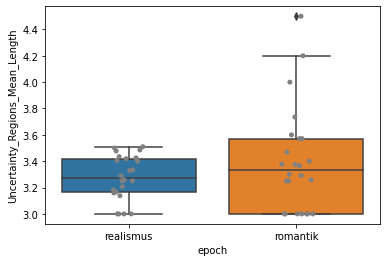

In [66]:
sns.boxplot(x="epoch", y="Uncertainty_Regions_Mean_Length", data=g_df_nsp)
sns.stripplot(x="epoch", y="Uncertainty_Regions_Mean_Length", color="gray", data=g_df_nsp)

### Combined

In [67]:
comb_df = g_df_sf.merge(g_df_nsp[["title", "Accuracy", "F1-Score", "Precision", "Recall", "n_sents"]], right_on="title", left_on="title", suffixes=["_SF", "_NSP"])
comb_df.head(3)

,epoch,title,author,Accuracy_SF,pub_year_estim,Precision_SF,Recall_SF,F1-Score_SF,Anzahl Teiltexte,Accuracy_NSP,F1-Score_NSP,Precision_NSP,Recall_NSP,n_sents
0,realismus,Angela Borgia,"Meyer,-Conrad-Ferdinand",0.916667,1891.0,0.857143,1.0,0.923077,12.0,0.778904,0.772188,0.796378,0.749424,2171
1,realismus,Barthli der Korber,"Gotthelf,-Jeremias",1.000000,1825.0,1.000000,1.0,1.000000,8.0,0.806042,0.784847,0.881134,0.707531,1142
2,realismus,Bozena,"Ebner-Eschenbach,-Marie-von",1.000000,1876.0,1.000000,1.0,1.000000,22.0,0.759492,0.757449,0.763939,0.751069,3977


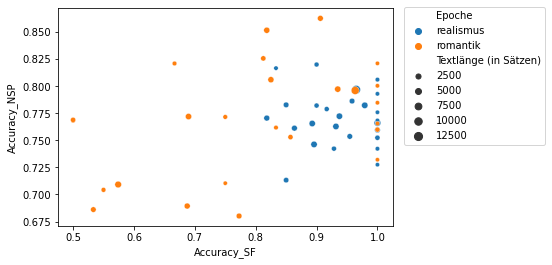

In [68]:
g = sns.scatterplot(x="Accuracy_SF", y="Accuracy_NSP", hue="Epoche", size="Textlänge (in Sätzen)", legend="brief", data=comb_df.rename({"epoch": "Epoche", "n_sents": "Textlänge (in Sätzen)"}, axis=1))
g.legend(loc='center left', bbox_to_anchor=(1.02, .69), ncol=1)
g.figure.savefig("../plots/acc_sf_nsf_scatter.png", bbox_inches='tight', dpi=200)

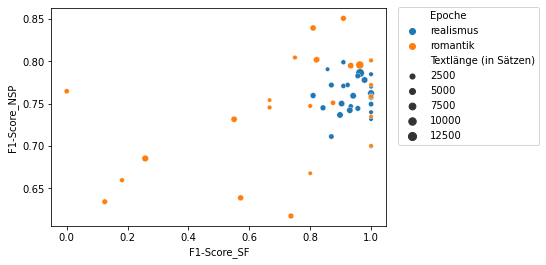

In [69]:
g = sns.scatterplot(x="F1-Score_SF", y="F1-Score_NSP", hue="Epoche", size="Textlänge (in Sätzen)", legend="brief", data=comb_df.rename({"epoch": "Epoche", "n_sents": "Textlänge (in Sätzen)"}, axis=1))
g.legend(loc='center left', bbox_to_anchor=(1.02, .69), ncol=1)
g.figure.savefig("../plots/f1_sf_nsf_scatter.png", bbox_inches='tight', dpi=200)

In [70]:
comb_df.query("epoch == 'romantik'").sort_values(by=["Accuracy_SF", "Accuracy_NSP"], ascending=False).tail(5)

,epoch,title,author,Accuracy_SF,pub_year_estim,Precision_SF,Recall_SF,F1-Score_SF,Anzahl Teiltexte,Accuracy_NSP,F1-Score_NSP,Precision_NSP,Recall_NSP,n_sents
42,romantik,Geschichte des Herrn William Lovell,"Tieck,-Ludwig",0.574074,1795.0,1.0,0.148148,0.258065,54.0,0.709181,0.685409,0.746423,0.633616,7080
38,romantik,Die Teutschen Volksbücher,"Goerres,-Joseph",0.550000,1812.0,1.0,0.100000,0.181818,20.0,0.704225,0.659689,0.776630,0.573357,1704
28,romantik,Clemens Brentanos Frühlingskranz,"Arnim,-Bettina-von",0.533333,1844.0,1.0,0.066667,0.125000,30.0,0.686024,0.634304,0.759396,0.544596,3599
46,romantik,Heinrich von Ofterdingen,Novalis,0.500000,1802.0,0.0,0.000000,0.000000,16.0,0.768877,0.764729,0.778705,0.751246,2609
43,romantik,Geschichte vom braven Kasperl und dem schönen ...,"Brentano,-Clemens",0.500000,1810.0,0.5,1.000000,0.666667,2.0,0.767992,0.754263,0.801706,0.712121,528


In [71]:
comb_df.query("epoch == 'romantik'").sort_values(by=["Accuracy_SF", "Accuracy_NSP"], ascending=False).head(5)

,epoch,title,author,Accuracy_SF,pub_year_estim,Precision_SF,Recall_SF,F1-Score_SF,Anzahl Teiltexte,Accuracy_NSP,F1-Score_NSP,Precision_NSP,Recall_NSP,n_sents
39,romantik,Die drei liebreichen Schwestern und der glückl...,"Arnim,-Ludwig-Achim-von",1.0,1806.0,1.0,1.0,1.0,4.0,0.821117,0.801549,0.900000,0.722513,573
51,romantik,Phantasien im Bremer Ratskeller,"Hauff,-Wilhelm",1.0,1827.0,1.0,1.0,1.0,4.0,0.800373,0.800992,0.798517,0.803483,804
31,romantik,Das Märchen von der blauen Grotte,"Waiblinger,-Wilhelm",1.0,1828.0,1.0,1.0,1.0,4.0,0.784704,0.772264,0.819625,0.730077,778
35,romantik,Die Glücksritter,"Eichendorff,-Joseph-von",1.0,1822.0,1.0,1.0,1.0,4.0,0.765564,0.734873,0.845570,0.649805,514
34,romantik,Die Briten in Rom,"Waiblinger,-Wilhelm",1.0,1828.0,1.0,1.0,1.0,12.0,0.759904,0.758379,0.763228,0.753592,2297


In [72]:
comb_df.query("epoch == 'realismus'").sort_values(by=["Accuracy_SF", "Accuracy_NSP"], ascending=False).tail(5)

,epoch,title,author,Accuracy_SF,pub_year_estim,Precision_SF,Recall_SF,F1-Score_SF,Anzahl Teiltexte,Accuracy_NSP,F1-Score_NSP,Precision_NSP,Recall_NSP,n_sents
27,realismus,Zwischen Himmel und Erde,"Ludwig,-Otto",0.863636,1856.0,1.000000,0.727273,0.842105,22.0,0.761232,0.745180,0.798887,0.698240,4318
16,realismus,Graf Petöfy,"Fontane,-Theodor",0.850000,1884.0,0.769231,1.000000,0.869565,20.0,0.782777,0.772016,0.812252,0.735578,3623
23,realismus,Stopfkuchen. Eine See- und Mordgeschichte,"Raabe,-Wilhelm",0.850000,1891.0,0.769231,1.000000,0.869565,20.0,0.713217,0.711239,0.716177,0.706369,3140
22,realismus,Ledwina,"Droste-Huelshoff,-Annette-von",0.833333,1822.0,0.750000,1.000000,0.857143,6.0,0.816667,0.790761,0.920886,0.692857,840
15,realismus,Geld und Geist,"Gotthelf,-Jeremias",0.818182,1843.0,0.850000,0.772727,0.809524,44.0,0.770546,0.759656,0.797509,0.725233,4502


In [73]:
comb_df.query("epoch == 'realismus'").sort_values(by=["Accuracy_SF", "Accuracy_NSP"], ascending=False).head(5)

,epoch,title,author,Accuracy_SF,pub_year_estim,Precision_SF,Recall_SF,F1-Score_SF,Anzahl Teiltexte,Accuracy_NSP,F1-Score_NSP,Precision_NSP,Recall_NSP,n_sents
1,realismus,Barthli der Korber,"Gotthelf,-Jeremias",1.0,1825.0,1.0,1.0,1.0,8.0,0.806042,0.784847,0.881134,0.707531,1142
17,realismus,Gustav Adolfs Page,"Meyer,-Conrad-Ferdinand",1.0,1861.0,1.0,1.0,1.0,4.0,0.792954,0.770075,0.865741,0.693449,809
12,realismus,Die einsamen Kinder,"Hebbel,-Friedrich",1.0,1838.0,1.0,1.0,1.0,4.0,0.775934,0.748837,0.851852,0.668050,723
21,realismus,Kleider machen Leute,"Keller,-Gottfried",1.0,1854.0,1.0,1.0,1.0,4.0,0.768411,0.757360,0.795309,0.722868,516
9,realismus,Die Judenbuche,"Droste-Huelshoff,-Annette-von",1.0,1839.0,1.0,1.0,1.0,4.0,0.767606,0.760058,0.785571,0.736150,1065


In [74]:
def merge(dfs):
    p_dfs = []
    for df in dfs:
        df = df.copy()
        df = df.rename({"title": "Title", "author": "Autor", "n_sents": "Anzahl Sätze"}, axis=1)
        df = df.drop(columns=["pub_year_estim", "epoch", "Precision_SF", "Recall_SF", "Precision_NSP", "Recall_NSP"], errors="ignore")
        p_dfs.append(df)
    return pd.concat(p_dfs).round(2)
                            

In [75]:
rom_merge_latex = merge([comb_df.query("epoch == 'romantik'").sort_values(by=["Accuracy_SF", "Accuracy_NSP"][::-1], ascending=False).tail(5), comb_df.query("epoch == 'romantik'").sort_values(by=["Accuracy_SF", "Accuracy_NSP"], ascending=False).head(5)])
print(rom_merge_latex.to_latex(index=False))

\begin{tabular}{llrrrrrr}
\toprule
                                             Title &                   Autor &  Accuracy\_SF &  F1-Score\_SF &  Anzahl Teiltexte &  Accuracy\_NSP &  F1-Score\_NSP &  Anzahl Sätze \\
\midrule
               Geschichte des Herrn William Lovell &           Tieck,-Ludwig &         0.57 &         0.26 &              54.0 &          0.71 &          0.69 &          7080 \\
                         Die Teutschen Volksbücher &         Goerres,-Joseph &         0.55 &         0.18 &              20.0 &          0.70 &          0.66 &          1704 \\
                                     Die Günderode &      Arnim,-Bettina-von &         0.69 &         0.57 &              48.0 &          0.69 &          0.64 &          4786 \\
                  Clemens Brentanos Frühlingskranz &      Arnim,-Bettina-von &         0.53 &         0.12 &              30.0 &          0.69 &          0.63 &          3599 \\
  Geschichte der poetischen Literatur Deutschlands & Eichendor

In [76]:
rea_merge_latex = merge([comb_df.query("epoch == 'realismus'").sort_values(by=["Accuracy_SF", "Accuracy_NSP"][::-1], ascending=False).tail(5), comb_df.query("epoch == 'realismus'").sort_values(by=["Accuracy_SF", "Accuracy_NSP"], ascending=False).head(5)])
print(rea_merge_latex.to_latex(index=False))

\begin{tabular}{llrrrrrr}
\toprule
                                    Title &                         Autor &  Accuracy\_SF &  F1-Score\_SF &  Anzahl Teiltexte &  Accuracy\_NSP &  F1-Score\_NSP &  Anzahl Sätze \\
\midrule
                          Uli der Pächter &            Gotthelf,-Jeremias &         0.90 &         0.90 &              48.0 &          0.75 &          0.74 &          6055 \\
                              Der Heilige &       Meyer,-Conrad-Ferdinand &         0.93 &         0.93 &              14.0 &          0.74 &          0.75 &          2144 \\
                 Der Schuß von der Kanzel &       Meyer,-Conrad-Ferdinand &         1.00 &         1.00 &               4.0 &          0.74 &          0.74 &           995 \\
                   Die Söhne des Senators &                Storm,-Theodor &         1.00 &         1.00 &               2.0 &          0.73 &          0.70 &           644 \\
Stopfkuchen. Eine See- und Mordgeschichte &                Raabe,-Wilhelm &  

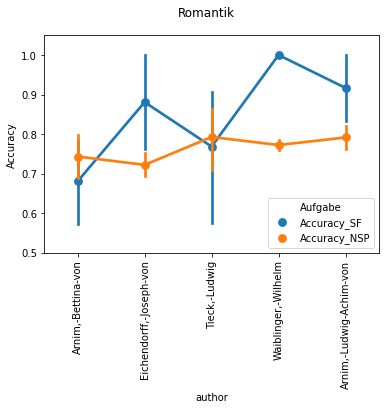

In [77]:
a_dfs_rom = []
for author in comb_df.query("epoch == 'romantik'").author.value_counts().iloc[:5].index:
    a_df = comb_df.query("author == @author")[["Accuracy_SF", "Accuracy_NSP"]].melt(var_name="Aufgabe", value_name="Accuracy")
    a_df["author"] = author
    a_dfs_rom.append(a_df)
a_df_rom = pd.concat(a_dfs_rom)
plt.ylim(0.5, 1.05)
#g = sns.boxplot(x="author", y="Accuracy", hue="Aufgabe", data=a_df_rom)
g = sns.pointplot(x="author", y="Accuracy", hue="Aufgabe", data=a_df_rom)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.figure.suptitle("Romantik")
g.figure.savefig("../plots/point_author_rom.png", bbox_inches = "tight", dpi=200)

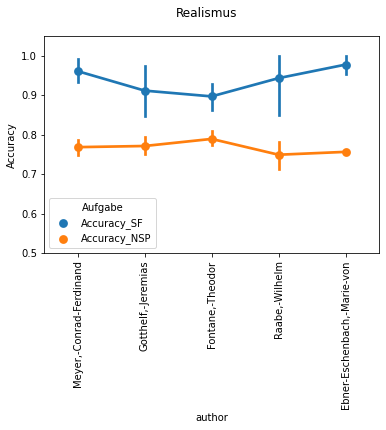

In [78]:
a_dfs_rea = []
for author in comb_df.query("epoch == 'realismus'").author.value_counts().iloc[:5].index:
    a_df = comb_df.query("author == @author")[["Accuracy_SF", "Accuracy_NSP"]].melt(var_name="Aufgabe", value_name="Accuracy")
    a_df["author"] = author
    a_dfs_rea.append(a_df)
a_df_rea = pd.concat(a_dfs_rea)
plt.ylim(0.5, 1.05)
#g = sns.boxplot(x="author", y="Accuracy", hue="Aufgabe", data=a_df_rea)
g = sns.pointplot(x="author", y="Accuracy", hue="Aufgabe", data=a_df_rea)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.figure.suptitle("Realismus")
g.figure.savefig("../plots/point_author_rea.png", bbox_inches = "tight", dpi=200)

# F1 

In [79]:
rom_merge_latex = merge([comb_df.query("epoch == 'romantik'").sort_values(by=["F1-Score_SF", "F1-Score_NSP"][::-1], ascending=False).tail(5), comb_df.query("epoch == 'romantik'").sort_values(by=["F1-Score_SF", "F1-Score_NSP"], ascending=False).head(5)])
print(rom_merge_latex.to_latex(index=False))

\begin{tabular}{llrrrrrr}
\toprule
                                             Title &                   Autor &  Accuracy\_SF &  F1-Score\_SF &  Anzahl Teiltexte &  Accuracy\_NSP &  F1-Score\_NSP &  Anzahl Sätze \\
\midrule
                                    Das Marmorbild & Eichendorff,-Joseph-von &         0.75 &         0.80 &               4.0 &          0.71 &          0.67 &           625 \\
                         Die Teutschen Volksbücher &         Goerres,-Joseph &         0.55 &         0.18 &              20.0 &          0.70 &          0.66 &          1704 \\
                                     Die Günderode &      Arnim,-Bettina-von &         0.69 &         0.57 &              48.0 &          0.69 &          0.64 &          4786 \\
                  Clemens Brentanos Frühlingskranz &      Arnim,-Bettina-von &         0.53 &         0.12 &              30.0 &          0.69 &          0.63 &          3599 \\
  Geschichte der poetischen Literatur Deutschlands & Eichendor

In [80]:
rea_merge_latex = merge([comb_df.query("epoch == 'realismus'").sort_values(by=["F1-Score_SF", "F1-Score_NSP"][::-1], ascending=False).tail(5), comb_df.query("epoch == 'realismus'").sort_values(by=["F1-Score_SF", "F1-Score_NSP"], ascending=False).head(5)])
print(rea_merge_latex.to_latex(index=False))

\begin{tabular}{llrrrrrr}
\toprule
                                    Title &                         Autor &  Accuracy\_SF &  F1-Score\_SF &  Anzahl Teiltexte &  Accuracy\_NSP &  F1-Score\_NSP &  Anzahl Sätze \\
\midrule
                 Der Schuß von der Kanzel &       Meyer,-Conrad-Ferdinand &         1.00 &         1.00 &               4.0 &          0.74 &          0.74 &           995 \\
                          Uli der Pächter &            Gotthelf,-Jeremias &         0.90 &         0.90 &              48.0 &          0.75 &          0.74 &          6055 \\
                                 Immensee &                Storm,-Theodor &         1.00 &         1.00 &               2.0 &          0.76 &          0.73 &           651 \\
Stopfkuchen. Eine See- und Mordgeschichte &                Raabe,-Wilhelm &         0.85 &         0.87 &              20.0 &          0.71 &          0.71 &          3140 \\
                   Die Söhne des Senators &                Storm,-Theodor &  

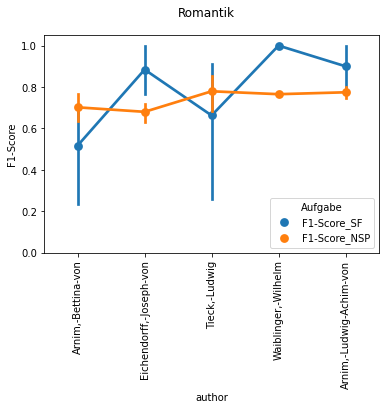

In [81]:
a_dfs_rom = []
for author in comb_df.query("epoch == 'romantik'").author.value_counts().iloc[:5].index:
    a_df = comb_df.query("author == @author")[["F1-Score_SF", "F1-Score_NSP"]].melt(var_name="Aufgabe", value_name="F1-Score")
    a_df["author"] = author
    a_dfs_rom.append(a_df)
a_df_rom = pd.concat(a_dfs_rom)
plt.ylim(0.0, 1.05)
#g = sns.boxplot(x="author", y="Accuracy", hue="Aufgabe", data=a_df_rom)
g = sns.pointplot(x="author", y="F1-Score", hue="Aufgabe", data=a_df_rom)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.figure.suptitle("Romantik")
g.figure.savefig("../plots/f1_point_author_rom.png", bbox_inches = "tight", dpi=200)

In [82]:
print(merge([comb_df.query("author in ['Arnim,-Bettina-von', 'Tieck,-Ludwig', 'Eichendorff,-Joseph-von']").sort_values("author")]).to_latex(index=False))

\begin{tabular}{llrrrrrr}
\toprule
                                             Title &                   Autor &  Accuracy\_SF &  F1-Score\_SF &  Anzahl Teiltexte &  Accuracy\_NSP &  F1-Score\_NSP &  Anzahl Sätze \\
\midrule
                  Clemens Brentanos Frühlingskranz &      Arnim,-Bettina-von &         0.53 &         0.12 &              30.0 &          0.69 &          0.63 &          3599 \\
Das Leben der Hochgräfin Gritta von Rattenzuhau... &      Arnim,-Bettina-von &         0.81 &         0.82 &              16.0 &          0.83 &          0.80 &          2808 \\
                                     Die Günderode &      Arnim,-Bettina-von &         0.69 &         0.57 &              48.0 &          0.69 &          0.64 &          4786 \\
              Goethes Briefwechsel mit einem Kinde &      Arnim,-Bettina-von &         0.69 &         0.55 &              58.0 &          0.77 &          0.73 &          5655 \\
                                    Das Marmorbild & Eichendor

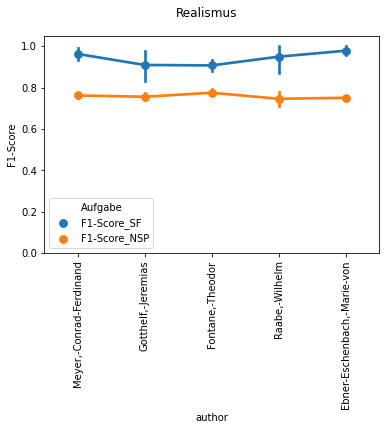

In [83]:
a_dfs_rea = []
for author in comb_df.query("epoch == 'realismus'").author.value_counts().iloc[:5].index:
    a_df = comb_df.query("author == @author")[["F1-Score_SF", "F1-Score_NSP"]].melt(var_name="Aufgabe", value_name="F1-Score")
    a_df["author"] = author
    a_dfs_rea.append(a_df)
a_df_rea = pd.concat(a_dfs_rea)
plt.ylim(0.0, 1.05)
#g = sns.boxplot(x="author", y="Accuracy", hue="Aufgabe", data=a_df_rea)
g = sns.pointplot(x="author", y="F1-Score", hue="Aufgabe", data=a_df_rea)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.figure.suptitle("Realismus")
g.figure.savefig("../plots/f1_point_author_rea.png", bbox_inches = "tight", dpi=200)